In [1]:
#Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# Import your local modules
from models.neural_net import PINN
from data.data_generator import load_normalized_data
from utils import plot_prediction_surface, compute_rmse,plot_loss_history,compute_errors, error_table, plot_final_time, plot_error_surface
from config import config

# Import training main
from main_train import main as train_model
# Import FD solver
from traditional.fd_solver import solve_heat_equation_fd


In [5]:
# from data.raw_data_processor import generate_processed_dataset
# from data.data_generator import load_normalized_data

# # Generate processed CSV
# csv_path = config['data_path']
# generate_processed_dataset(date_cutoff='2021-01-01', output_path=csv_path)

# # Load data for evalua, X_test, u_test = load_normalized_data(
# #     csv_path,
# #     n_collocation=config['n_collocation'],
# #     split_ratio=config['train_test_split'],
# #     device=config['device']
# # )

Saved normalized dataset to: D:/Programming/Summer-2025-DL-Project-PINN/data/covid_county_cases.csv


Training the model using main()
Starting PINN Training Pipeline
Using device: cpu

Loading and preprocessing data...
Loading and normalizing dataset from: D:/Programming/Summer-2025-DL-Project-PINN/data/covid_county_cases.csv
Loaded and processed: 856724 samples
Training points: 685379 | Test points: 171345 | Collocation points: 10000
Initializing PINN architecture...
Starting training loop...
[INFO] Starting Adam warm-up phase
[Adam 00000] Loss: 8.354970e-01
[Adam 00500] Loss: 1.987408e-02
[Adam 00999] Loss: 1.707868e-02
[Adam 01000] Loss: 1.707759e-02
[Adam 01500] Loss: 1.679461e-02
[Adam 02000] Loss: 1.660332e-02
[Adam 02500] Loss: 1.641326e-02
[Adam 03000] Loss: 1.623173e-02
[Adam 03500] Loss: 1.695511e-02
[Adam 04000] Loss: 1.599829e-02
[Adam 04500] Loss: 1.590369e-02
[INFO] Starting LBFGS phase
[INFO] LBFGS optimization completed.
Evaluating model...
RMSE on test set: 0.148810


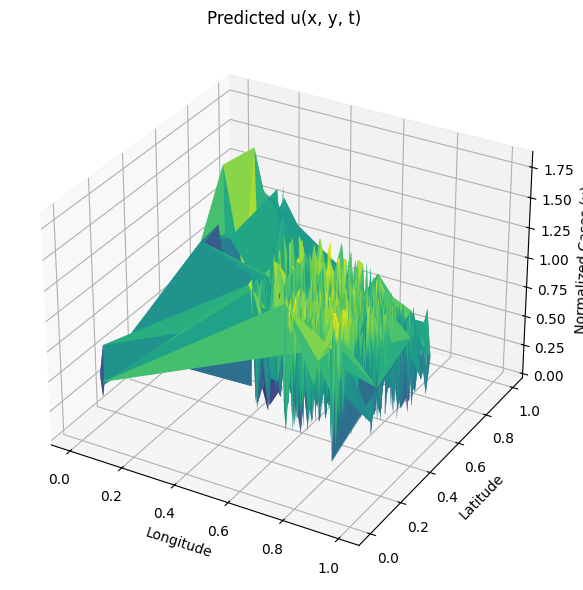

Model checkpoint saved to: D:/Programming/Summer-2025-DL-Project-PINN/checkpoints/model.pth



In [2]:
#Train the model from scratch and save it
print("Training the model using main()")
train_model()


**We load the trained PINN model using the architecture defined in neural_net.py. This allows evaluation on unseen test points.**

In [2]:
# Load trained model
print("Loading trained model...")
device = torch.device(config["device"])

model = PINN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    hidden_layers=config["hidden_layers"],
    output_dim=config["output_dim"]
).to(device)

checkpoint_path = config["checkpoint_path"]
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"Model loaded from: {checkpoint_path}")


Loading trained model...
Model loaded from: D:/Programming/Summer-2025-DL-Project-PINN/checkpoints/model.pth


In [3]:
# Load test data
_, _, _, X_test, u_test = load_normalized_data(config["data_path"],
                                               n_collocation=config["n_collocation"],
                                               split_ratio=config["train_test_split"],
                                               device=device)

# Predict and compute RMSE
with torch.no_grad():
    u_pred = model(X_test)
    rmse = compute_rmse(u_pred, u_test, apply_expm1=True)
    print(f"RMSE on test set: {rmse:.6f}")
    
# Convert tensors to NumPy
X_test_np = X_test.cpu().numpy()
u_test_np = u_test.cpu().numpy()
u_pred_np = u_pred.cpu().numpy()

Loading and normalizing dataset from: D:/Programming/Summer-2025-DL-Project-PINN/data/covid_county_cases.csv
Loaded and processed: 856724 samples
Training points: 685379 | Test points: 171345 | Collocation points: 10000
RMSE on test set: 0.148810


**We compute RMSE to measure the model's generalization error on unseen spatiotemporal points**

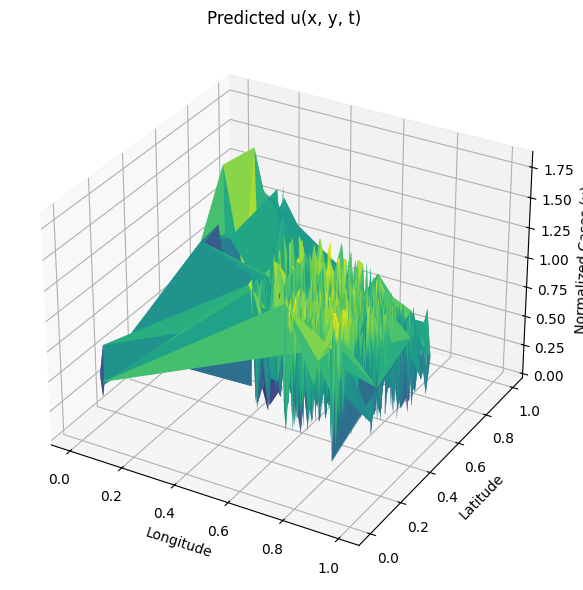

In [5]:
# Visualize surface plot
plot_prediction_surface(X_test, u_pred, title="Predicted u(x, y, t)")

**This surface plot visualizes the predicted values of the normalized case count across 3D input space (lon, lat, time)**

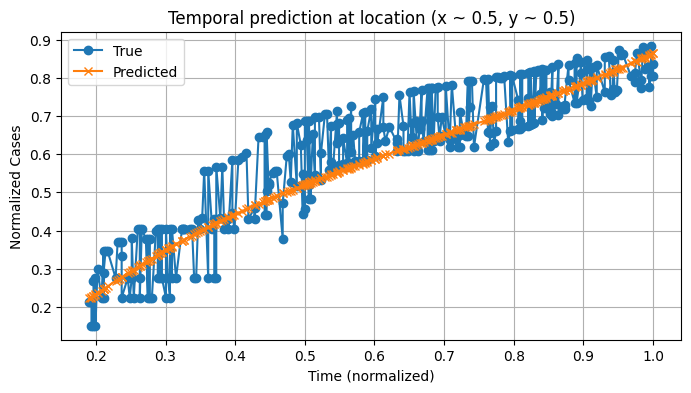

In [6]:
# Pick a location (x, y) close to [0.5, 0.5]
mask = np.abs(X_test_np[:, 0] - 0.5) < 0.01  # lon ~ 0.5
mask &= np.abs(X_test_np[:, 1] - 0.5) < 0.01  # lat ~ 0.5

x_slice = X_test_np[mask]
u_true_slice = u_test_np[mask]
u_pred_slice = u_pred_np[mask]

if len(x_slice) > 0:
    idx = np.argsort(x_slice[:, 2])  # sort by time
    plt.figure(figsize=(8, 4))
    plt.plot(x_slice[idx, 2], u_true_slice[idx], label="True", marker='o')
    plt.plot(x_slice[idx, 2], u_pred_slice[idx], label="Predicted", marker='x')
    plt.xlabel("Time (normalized)")
    plt.ylabel("Normalized Cases")
    plt.title("Temporal prediction at location (x ~ 0.5, y ~ 0.5)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No points found near (0.5, 0.5). Try adjusting location mask.")

**Here we visualize the predicted time evolution of COVID-19 cases at a fixed location to evaluate dynamic consistency**

**Run Finite Difference Solver**

In [8]:
u_fd, X_fd, Y_fd = solve_heat_equation_fd()

In [4]:
# Try loading pre-saved FD solution; generate if not found
fd_path = config["fd_path"]

if os.path.exists(fd_path):
    print("Loading FD solution from file...")
    fd_data = np.load(fd_path)
    u_fd = fd_data["u"]
    X_fd = fd_data["X"]
    Y_fd = fd_data["Y"]
else:
    print("FD solution not found. Generating it now...")
    from traditional.fd_solver import solve_heat_equation_fd
    u_fd, X_fd, Y_fd = solve_heat_equation_fd(nx=100, ny=100, nt=100, T=1.0)
    np.savez(fd_path, u=u_fd, X=X_fd, Y=Y_fd)
    print(f"FD solution saved to {fd_path}")


FD solution not found. Generating it now...
FD solution saved to D:/Programming/Summer-2025-DL-Project-PINN/data/fd_solution.npz


D:\Programming\Summer-2025-DL-Project-PINN\traditional\fd_solver.py:36: RuntimeWarning: overflow encountered in cast
  u_fd[n] = u.copy()


In [5]:
from scipy.interpolate import griddata

# Flatten FD meshgrid to (N, 2)
fd_coords = np.column_stack([X_fd.ravel(), Y_fd.ravel()])

# Interpolate PINN predictions onto FD grid
u_pinn_interp = griddata(
    X_test.cpu().numpy()[:, :2], 
    np.expm1(u_pred.cpu().numpy().flatten()), 
    fd_coords, 
    method='linear'
).reshape(X_fd.shape)

# Compare to final time slice of FD
u_fd_final = u_fd[-1]


In [6]:
# Absolute error between PINN and FD
error = np.abs(u_pinn_interp - u_fd_final)


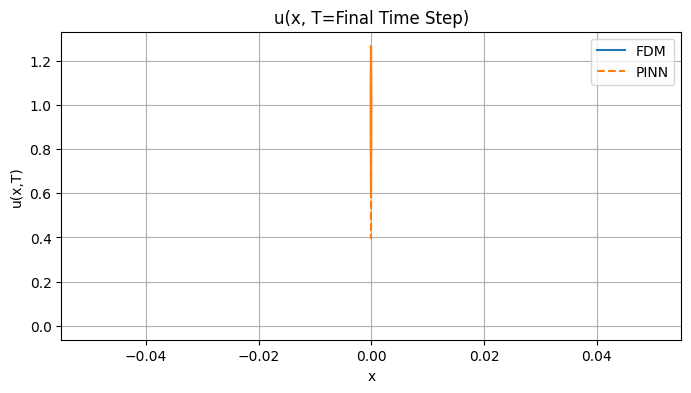

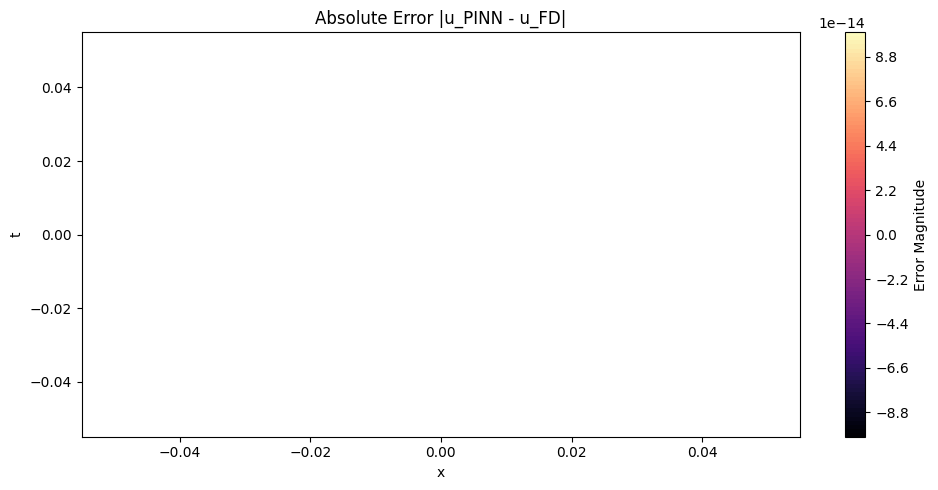

In [7]:
# Plot FD vs PINN at final time step
plot_final_time(X_fd[0], u_fd_final[X_fd.shape[0]//2], u_pinn_interp[X_fd.shape[0]//2], T="Final Time Step")
plot_error_surface(X_fd[0], Y_fd[:, 0], error, title="Absolute Error |u_PINN - u_FD|")


**Plot side-by-side comparison**

ValueError: Argument Z must be 2-dimensional.

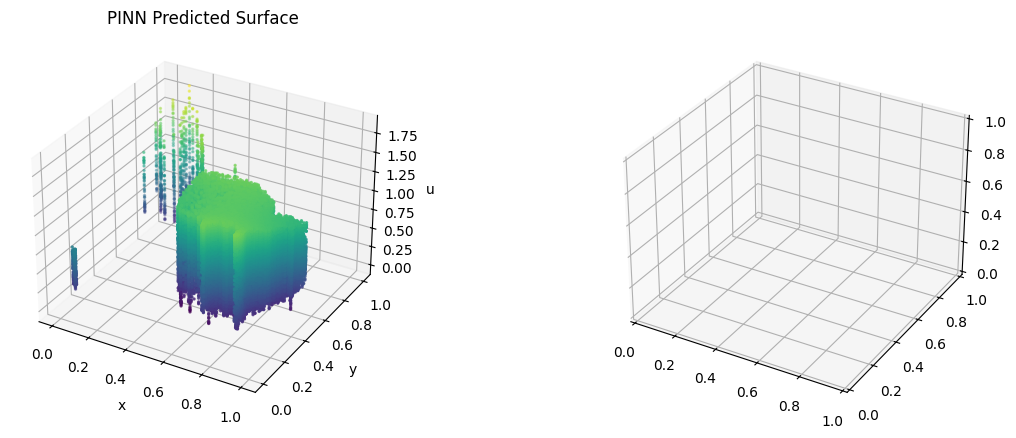

In [8]:
fig = plt.figure(figsize=(14, 5))


"""
3D surface plot of predicted u(x, y, t).
Applies inverse log1p to bring prediction to original scale.
"""
if isinstance(u_pred, torch.Tensor):
    u_plot = torch.expm1(u_pred).cpu().numpy()
else:
    u_plot = np.expm1(u_pred)

if isinstance(X_test, torch.Tensor):
    X_np = X_test.cpu().numpy()
else:
    X_np = X_test

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.scatter(X_np[:, 0], X_np[:, 1], u_plot[:, 0], c=u_plot[:, 0], cmap="viridis", s=2)
ax1.set_title("PINN Predicted Surface")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("u")

# FD Solution
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(X_fd, Y_fd, u_fd, cmap="plasma")
ax2.set_title("Finite Difference Solution")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("u")

plt.tight_layout()
plt.show()


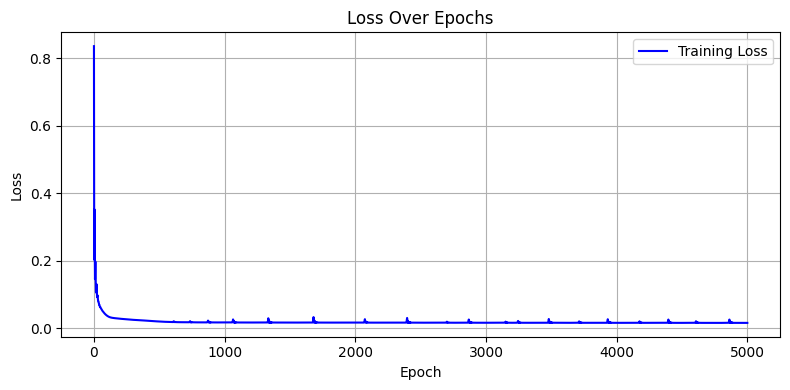

In [9]:
with open("checkpoints/loss_history.pkl", "rb") as f:
    loss_history = pickle.load(f)

plot_loss_history(loss_history)

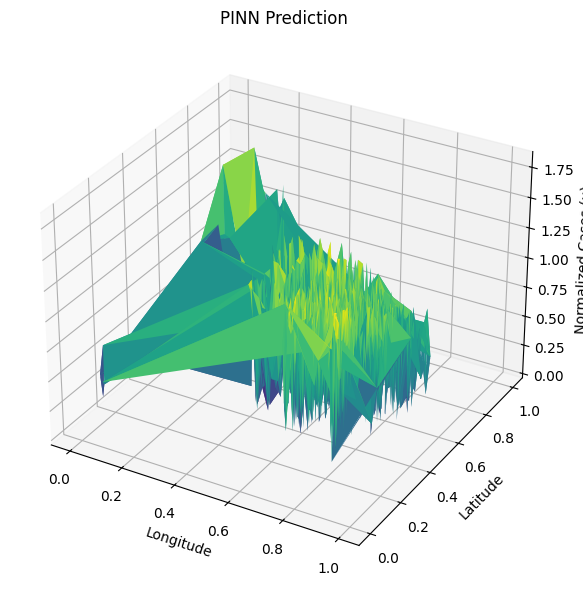

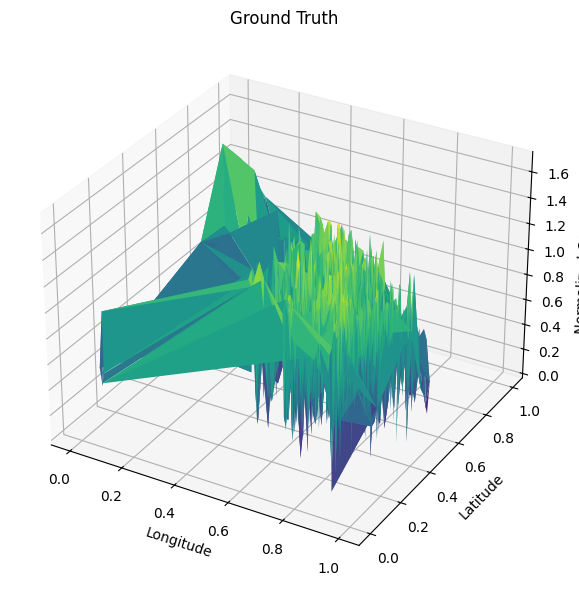

In [10]:
plot_prediction_surface(X_test, u_pred, title="PINN Prediction")
plot_prediction_surface(X_test, u_test, title="Ground Truth")


In [11]:
# Assuming u_pred and u_test are available
errors = compute_errors(u_pred.cpu().numpy(), u_test.cpu().numpy())
display(error_table(errors))


,Metric,Value
0,Relative L2 Error,1.31e-01
1,Max Abs Error,4.85e-01


In [14]:
# Load predicted and true test data from PINN (assume already available)
# u_pred: predicted values (log scale)
# u_test: ground truth (log scale)
# X_test: input coordinates

# Load FD reference solution
fd_data = np.load(config["fd_path"])
u_fd = fd_data["u"]
X_fd = fd_data["X"]
Y_fd = fd_data["Y"]

# Reshape PINN output for last time step only
# Example: assume u_pred was reshaped or collected for final time slice
# You should map it based on (lon, lat) grid matching FD dimensions

# Dummy mapping: (for actual, match spatial coords)
u_pinn_grid = u_pred.cpu().detach().numpy().reshape(u_fd.shape)
error = np.abs(np.expm1(u_pinn_grid) - u_fd)

# Plot comparison
plot_final_time(X_fd[0], u_fd[int(len(X_fd)/2)], u_pinn_grid[int(len(X_fd)/2)], T="Final")
plot_error_surface(X_fd[0], Y_fd[:, 0], error, title="Absolute Error |u_PINN - u_FD|")


ValueError: cannot reshape array of size 171345 into shape (100,100,100)